# 🤖 Computer Vision course: Practical Guide 😎
> With Transfer Learning, custom CNN, Ensemble, TPUs, and lots of plain English comments

![Petals to the metal](https://user-images.githubusercontent.com/115424463/267539825-8e845684-c60a-4bc9-838d-f0b800e317b9.jpeg)

> Picture: Petals to the Metal

# Hello, fellow data enthusiasts 🤓!

After completing [Computer Vision](https://www.kaggle.com/learn/computer-vision) microcourse and studying the [examplary notebook](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission) I felt there might be some public interest in a work that smooths transition from the theory to [Petals to the Metal](https://www.kaggle.com/c/tpu-getting-started) competition. Personally, I needed a Notebook with more English and less Python to 'get started' with this topic. Now, you have one. 

_In this Notebook you will find_:

- The comprehensively commented [utility code](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission) to run Tensor Processing Units (TPU). The code is structured to serve as a collection of logical blocks that you can use for EDA and modeling with your own strategies.
- An example of **transfer learning** with __Xception__
- A custom __Convolutional Neural Network__ as adviced in the course. Models are trained and serialized for your convinience.
- Several essential tools (__callbacks__), not mentioned in the course: _EarlyStopping, LearningRateSchedule, Checkpoints_
- __Ensemble of models__ and a voting strategy.


_Project Scopes_:
- No groundbreaking decisions on achieving a high score.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions </strong> <br> 
    </blockquote>

# STEP 0: Imports

In [4]:
import math, re, os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers as L
from keras.layers.experimental import preprocessing
from keras.preprocessing import image_dataset_from_directory
from keras.applications import Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib

from sklearn.metrics import f1_score

from warnings import simplefilter
simplefilter("ignore")


print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.14.0


# STEP 1: Connect to Tensor Processing Units (TPUs)

Kaggle provides a limited access to 3 types of processing units, avaliale for your models' training.
- Central Processing Units (**CPUs**)
- Graphics Processing Units (**GPUs**)
- Tensor Processing Units (**TPUs**)

Here is an [**article**](https://towardsdatascience.com/when-to-use-cpus-vs-gpus-vs-tpus-in-a-kaggle-competition-9af708a8c3eb) to help you figure out which is which. Long story short, "GPUs are a great alternative to CPUs when you want to speed up a variety of data science workflows, and TPUs are best when you specifically want to train a machine learning model as fast as you possibly can". But you will have to work on the code to make your data digestable for a TPU.

A TPU has **eight cores** (it's like having eight GPUs in one machine). With **distribution strategy**, we instruct TensorFlow on how to utilize all these cores simultaneously. We will employ this object when constructing our neural network model: it will distribute the training by generating eight distinct *replicas* of the model, one for each core.

In [7]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # An attempt to detect an avaliable TPU (to 'resolve a TPU cluster')
    print('Running on TPU ', tpu.master())                     # Tell the world that the attempt was a success
except ValueError:
    tpu = None

if tpu:                                                        # If TPU was detected
    tf.config.experimental_connect_to_cluster(tpu)             # connect to the TPU cluster 
    tf.tpu.experimental.initialize_tpu_system(tpu)             # run the cluster
    strategy = tf.distribute.TPUStrategy(tpu)                  # create a distribution strategy for TPU training
else:
    strategy = tf.distribute.get_strategy()                    # If no TPU was found, use the default distribution strategy for CPU or GPU

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

In [8]:
# Tell the world which strategy it is
print("REPLICAS: ", strategy.num_replicas_in_sync) 

REPLICAS:  8


In [9]:
# Set how many files can be processed simultaniously. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Step 2: Retrieve, Load and Format Data

- When used with TPUs, datasets need to be stored in a [Google Cloud Storage bucket](https://cloud.google.com/storage/) (**GCS**). You can use data from any public GCS bucket by giving its path (like `'/kaggle/input'`). 
- You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).
- When used with TPUs, datasets are serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format for distributing data to each of the TPUs cores.

In [10]:
# Here we create lists of paths to our training, validation and test files
from kaggle_datasets import KaggleDatasets

IMAGE_SIZE = [192, 192]    # This is the size for GPU. For TPU use [512, 512]
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')   # You can list the bucket with "!gsutil ls $GCS_DS_PATH"
                 
GCS_PATH_SELECT = {                                                      # Images of different sizes are strored in different directories. The dictionary connects the sizes to the paths
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}

GCS_PATH_PER_SIZE = GCS_PATH_SELECT[IMAGE_SIZE[0]]                       # Define the path to the directory depending on the IMAGE_SIZE
GCS_PATH_ORIGINAL = GCS_DS_PATH + GCS_PATH_PER_SIZE                      # This is where the original data for the competition dwells


TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH_ORIGINAL  + '/train/*.tfrec')  # Get the list of file paths for training TFRecords
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH_ORIGINAL + '/val/*.tfrec')   # Get the list of file paths for validation TFRecords
TEST_FILENAMES       = tf.io.gfile.glob(GCS_PATH_ORIGINAL + '/test/*.tfrec')  # Get the list of file paths for testing TFRecords

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [11]:
# I saved the list with flower labels in a separate .csv
CLASSES = pd.read_csv('/kaggle/input/cv-course-practical-guide-data/flower_classes.csv', usecols = ['flowers']).squeeze().sort_values().to_list()

In [12]:
'''
The following code allows to create sets of TFRecords. This is a special data format suitable for processing on TPU.
If not for TPU, we could have easily use `keras.preprocessing.image_dataset_from_directory()`
'''

AUTO = tf.data.experimental.AUTOTUNE                     # Configure Auto-tuning for better performance. To be applied in many functions below                                                                                                                                # 100 - 102

def decode_image(image_data):                            
    image = tf.image.decode_jpeg(image_data, channels=3) # Decode the JPEG image to a tensor with 3 color channels (red, green, blue)
    image = tf.cast(image, tf.float32) / 255.0           # Convert pixel values to floating-point numbers in the range [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])          # Reshape the image tensor to match the specified IMAGE_SIZE
                                                         # This step ensures that all images have the same dimensions for consistency
    return image

# This function reads a labeled TFRecord file and returns the image and its corresponding label (to be applied on training and validation sets)
def read_labeled_tfrecord(example):                                     # example: A single labeled TFRecord file (labled picture to be used for training and validation)
    LABELED_TFREC_FORMAT = {                                            # setting a dictionary that defines the format of a TFRecord (names and dtypes of its features)
        "image": tf.io.FixedLenFeature([], tf.string),                  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),                   # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT) # Parse the single TFRecord example according to the specified format.
    image = decode_image(example['image'])                              # Decode the 'image' feature of a TFRecord file using the 'decode_image' function (previously defined)                         
    label = tf.cast(example['class'], tf.int32)                         # tf.cast converts tensors from one data type to another. Here it ensures that all elements are integers
    return image, label                                                 # returns a dataset of (image, label) pairs. In Python you get a tuple with this syntaxis automatically


# This function reads an unlabeled TFRecord file and returns the image and its ID (to be applied on the test set)
def read_unlabeled_tfrecord(example):                       
    UNLABELED_TFREC_FORMAT = {                             
        "image": tf.io.FixedLenFeature([], tf.string),     
        "id": tf.io.FixedLenFeature([], tf.string),                       # Class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT) # Parse the single TFRecord example according to the specified format.
    image = decode_image(example['image'])                                # Decode the 'image' feature of a TFRecord example using the 'decode_image' function (previously defined)
    idnum = example['id']
    return image, idnum                                                   # Returns a dataset of (image, id) pairs. In Python you get a tuple with this syntaxis automatically


# Read from TFRecords. For optimal performance, reading from multiple files at once and disregarding data order.
def load_dataset(filenames, labeled=True, ordered=False):                 # We set values for 'labeled' and 'ordered' in the definition of the function to use them by default. However, we reserve an option to pass different values to these parameters.
    
    options = tf.data.Options()                                           # Creating an objects here looks like a TensorFlow reference code. It is literally the same as in the documentation
    if not ordered:                                                       # If the 'ordered' parameter is 'False' (the default) and hasn't been explicitly set to 'True' when passed to the function
        options.deterministic = False                                     # Disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files. This 'num_parallel_reads=AUTO' parameter of tf.data.TFRecordDataset() will be used many times in the below code.
    dataset = dataset.with_options(options)                               # uses data as soon as it streams in, rather than in its original order
                          
                          # returns a dataset of (image, label) pairs if labeled=True
    dataset = dataset.map(read_labeled_tfrecord if labeled \
                          # returns a dataset of (image, id) pairs if labeled=False
                          else read_unlabeled_tfrecord,
                          num_parallel_calls=AUTO)                        
    return dataset

# Step 3: Create Pipelines 

In [13]:
def data_augment(image, label):
    seed  = 42                                                       # Setting the seed ensures reproducibility; otherwise, the learning process can produce different results each time, making it hard to control.
    image = tf.image.random_flip_left_right(image, seed=seed)        # These functions are included here to make you aware of their existence, but not all of them necessarily yield optimal performance on the given dataset.
    image = tf.image.random_flip_up_down(image, seed=seed)
#   image = tf.image.random_saturation(image, 0, 2, seed=seed)       # It doesn't seem a great idea to change colours of flowers. But it could work on images of a different kind
#   image = tf.image.random_brightness(image, 0.6, seed=seed)
#   image = tf.image.random_contrast(image, 0.3, 0.5, seed=seed)
    
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)        # Check load_dataset function and recall that 'dataset = tf.data.TFRecordDataset()'' with its inherent parameters
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)    # Apply data_augment function
    dataset = dataset.repeat()                                      # The repeat method is called on the dataset to make it repeat indefinitely (for all the epochs)
    dataset = dataset.shuffle(2048)                                 # Shuffling the data is important during training to prevent the model from memorizing the order 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)                                # Prefetch next batch while training. Thanks to this statement, data pipeline code is executed on the CPU, 
                                                                    # saving the TPU capacities for computing gradients.
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered) # 'ordered=ordered' passes the 'ordered' parameter's value from the overarching function 'get_validation_dataset'
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()                                                   # Caching the dataset means that it is temporarily stored in RAM, making it faster to access during subsequent epochs 
    dataset = dataset.prefetch(AUTO)                                            
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):             # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items                            
    n = [int(re.compile(r"-([0-9]*)\.")      # This is a 'regular expression'. re.compile() creates here a pattern where a number appears between a hyphen and a period, 
               .search(filename)             # looks for the pattern in the filenames
               .group(1))                    # returns what was found. re.group() regulates which part of a pattern to return: re.group(0) returns the entire matched pattern, and re.group(n) returns the respective subpattern if the pattern contains a number of them.
                for filename in filenames]                          
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES     = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES   = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES         = count_data_items(TEST_FILENAMES)

print(f'Dataset: \n'
      f'{NUM_TRAINING_IMAGES} training images \n'
      f'{NUM_VALIDATION_IMAGES} validation images \n'
      f'{NUM_TEST_IMAGES} unlabeled test images')

Dataset: 
12753 training images 
3712 validation images 
7382 unlabeled test images


In [15]:
'''
Here we create the datasets (traning, validation and test)
- These datasets are `tf.data.Dataset` objects. You can think about a dataset in TensorFlow as a *stream* of data records. 
- The training and validation sets are streams of `(image, label)` pairs.
- The test set is a stream of `(image, idnum)` pairs; we'll use these `idnum` (ID numbers) later to make our submission `csv` file.
'''

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test  = get_test_dataset()

In [16]:
# Let's take a look at the data shapes
np.set_printoptions(threshold=15, linewidth=80)          # Set the print options for NumPy to control the way arrays are displayed. This is in order to display only a part rather then all the information

print("Training data shapes:")
for image, label in ds_train.take(3):                    # Iterate through the first 3 elements of the training dataset
    print(image.numpy().shape, label.numpy().shape)      # .numpy() converts a TensorFlow tensor to a NumPy array
print("Training data label examples:", label.numpy())

print ('---')

print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [ 4 75 43 ... 52 21 49]
---
Test data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Test data IDs: ['50de80a98' 'a2aa2199a' 'c476f6495' ... 'e5a6a39de' 'fac9307e4' '524961d31']


# Step 4: Explore Data #
Let's take a moment to look at some of the images in the dataset.

In [17]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data                                          # unpack the tuples of (image, label) and (image, idnum). See above read_labeled_tfrecord and read_unlabeled_tfrecord functions
    numpy_images   = images.numpy()                                # .numpy() converts a TensorFlow tensor to a NumPy array
    numpy_labels   = labels.numpy()
    if numpy_labels.dtype == object:                               # Remember,that in our case`label` is tf.int64 (numeric format) and `idnum` is tf.string (bytestring, an `object`) 
        numpy_labels = [None for _ in enumerate(numpy_images)]     # So, if numpy_labels ends up carring 'idnum' values (not the 'labels'), this statement sets them to None (for test data)
    return numpy_images, numpy_labels


# A function to generate a title based on the predicted and true target values
def title_from_label_and_target(label, correct_label):             # it takes predictions (labels) and true values (correct_label) as arguments
    if correct_label is None:                                      # if we deal with the test set, where no correct_labels are availible 
        return CLASSES[label], True                                # it simply returns the prediction
    
    correct = (label == correct_label)                             # if target value (correct_label) is availible, it compares it with the prediction and returns a boolean value (True/False)
    
    return "{} [{}{}{}]".format(CLASSES[label],                    # returns the prediction
            'OK' if correct else 'NO',                             # 'OK' if it is True, 'NO'          if it is False
            u"\u2192" if not correct else '',                      # ''   if it is True, '→'           if it is False 
            CLASSES[correct_label] if not correct else ''),correct # ''   if it is True, correct_label if it is False, separate value for 'True' or 'False'
                                                         
                                                            

    
# a function to display a single flower image with a title
def display_one_flower(image, title, subplot,                       # subplot is what you need to display several pictures at once (on one plot)
                       red=False, titlesize=16):
    plt.subplot(*subplot)                                           # '*subplot' syntax unpacks the values in the subplot tuple (rows, columns, index) that specify the subplot layout 
    plt.axis('off')
    plt.imshow(image)                                               # plt.imshow stands for 'show image'
    if len(title) > 0:                                                    # if title is avaliable
        plt.title(title,                                                  # set parameters for this title's display
          fontsize = int(titlesize) if not red else int(titlesize/1.2),   # bigger fontsize for correct (black) titles, smaller fontsize for the wrong (red) titles
          color='red' if red else 'black',                                # depending on the argument passed to the function
          fontdict={'verticalalignment':'center'}, 
          pad=int(titlesize/1.5))
    
    return (subplot[0],                                                   # the number of rows in the subplot grid
            subplot[1],                                                   # the number of columns in the subplot grid
            subplot[2]+1)                                                 # the current index (position) within the grid. +1 makes it an iterator: each time you call this funtion, it moves to the next image
    

# this function makes several pictures appear on the screen at the same time
def display_batch_of_images(databatch, predictions=None):
    """This functions works with following settings:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    images, labels = batch_to_numpy_images_and_labels(databatch) # data
    if labels is None:
        labels = [None for _ in enumerate(images)]               # creates a list of None values with the same length as the images list: to ensure that there is a label for each image.
    rows = int(math.sqrt(len(images)))                           # auto-squaring: this will drop data from the display that does not fit into square or square-ish rectangle
    cols = len(images)//rows                                     # calculates the number of columns based on the number of rows and the total number of images. It uses integer division (//) to ensure that the grid is as square as possible.
        
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows,cols,1)                                      # you allready know that subplot has three parameters: (rows, columns, index)
    if rows < cols:                                              # if there are more columns then rows
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))          # set portrait (tall) orientation
    else:                                                        # if the are more rows then colums
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))          # set landscape (wide) orientation
    
    # display
    display_dict = zip(images[:rows*cols], labels[:rows*cols])                      # a dictionary with a subset of images as keys and a subset of labels as values. The subsets start from the beginning and contain rows*cols elements 
    for i, (image, label) in enumerate (display_dict):                              # an iterator
        title = '' if label is None else CLASSES[label]                             # determine the title for the subplot based on the label
        correct = True                                                              # set the default value for 'correct'
        if predictions is not None:                                                 # if predictions are passed to the function
            title, correct = title_from_label_and_target(predictions[i], label)     # apply the above formular, passing the predictions' indexes from the iterator and the corresponding labeles 
        dynamic_titlesize  = FIGSIZE*SPACING/max(rows,cols)*40+3                    # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, 
                                     not correct,                                   # this is a value for parameter 'red' of display_one_flower function. So, if the prediction is False (correct=False), were turn it around (not correct) and pass True (red=True) to the function
                                     titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()                                                # ensure that the subplots (in this case, the displayed images and titles) fit within the figure without overlapping or being cut off.
    if label is None and predictions is None:                         # if there are no predictions and true labels     
        plt.subplots_adjust(wspace=0, hspace=0)                       # no spacing between the images             
    else:                                                             # otherwise
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)           # make spaces
    plt.show()

In [18]:
'''
- You can display a single batch of images from a dataset with this helper functions. 
- He we turn the dataset into an iterator of batches of 20 images.
'''
ds_iter = iter(ds_train.unbatch().batch(20))

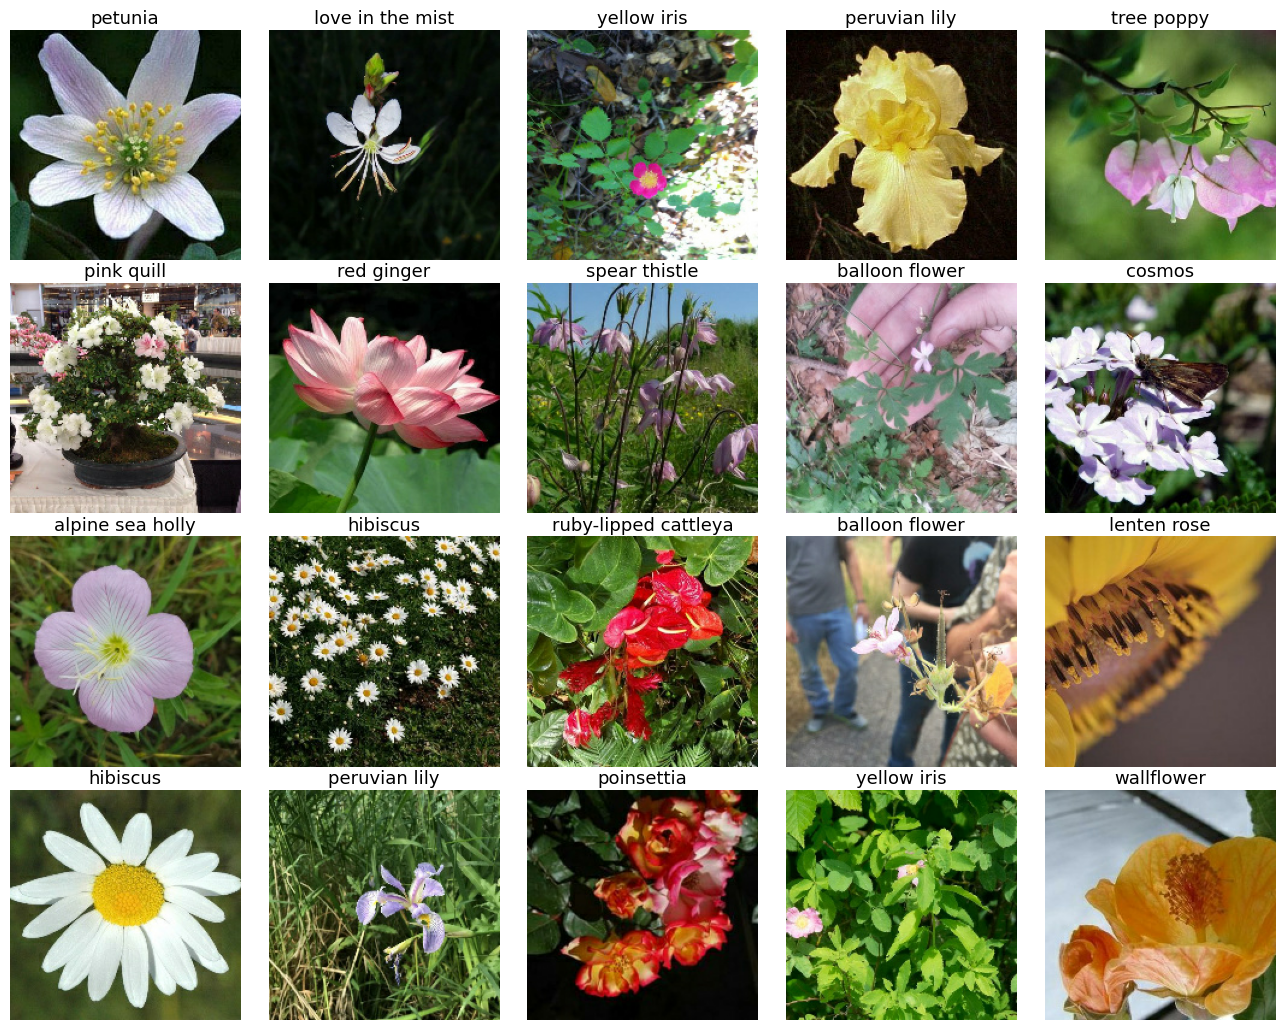

In [19]:
'''
- `next` function allows to fetch next batch in the stream and display it with the helper function.
- Rerun this cell to see a new batch of images.
'''
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# Step 5: Callbacks
- A callback is a .fit() parameter, where you can pass different objects:
- **`Learning Rate Schedule`**: adjusts the learning rate e.g. after a certain number of epochs or when the training loss plateaus or else
- **`Early Stopping`**: stops learning if there is no improvement after several epochs
- **`Checkpoint`**: saves weights at the end of every epoch, if it's the best seen so far during model.fit

- There are [many other options](https://keras.io/api/callbacks/). But we will make these three here.
We will apply the same callbacks for all the models that follow.

In [20]:
EPOCHS = 30                                           # EarlyStopping should break it sooner
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE   # Batches per epoch

### Callback 1: learning rate schedule

Learning rate schedule: 
from 1e-05 
to 5e-05 
and then back to 1.02e-05


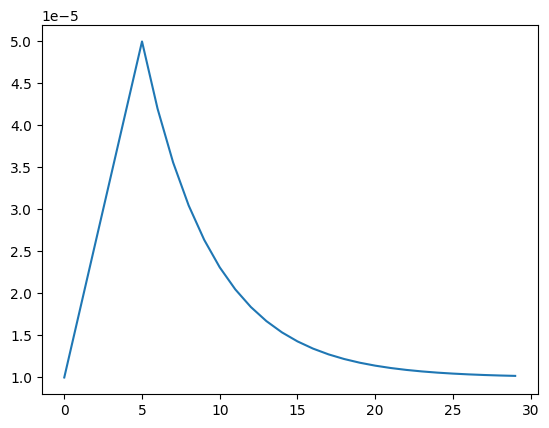

In [21]:
def exponential_lr(epoch,                                   # The current training epoch
                   start_lr = 0.00001,                      # The initial learning rate
                   min_lr = 0.00001,                        # The minimum learning rate
                   max_lr = 0.00005,                        # The maximum learning rate
                   rampup_epochs = 5,                       # The number of epochs for a linear increase in learning rate
                   sustain_epochs = 0,                      # The number of epochs to sustain the maximum learning rate
                   exp_decay = 0.8):                        # The exponential decay factor for learning rate reduction

    # calculates the learning rate for a given epoch based on the provided parameters
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay): 
        
        if epoch < rampup_epochs:                             # For epochs less than rampup_epochs, the learning rate increases from start_lr to max_lr.
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        
        elif epoch < rampup_epochs + sustain_epochs:          # From 'rampup_epochs' till 'rampup_epochs + sustain_epochs', the learning rate remains constant at max_lr
            lr = max_lr
        
        else:                                                 # exponential decay towards min_lr
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

# This is what it was all about. We pass our customary funtion to the keras LearningRateScheduler to create a callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)  

# plot our customary learning rate per epoch
rng = [i for i in range(EPOCHS)]     
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print(f'Learning rate schedule: \n'
      f'from {y[0]:.3g} \n'
      f'to {max(y):.3g} \n'
      f'and then back to {y[-1]:.3g}')

### Callback 2: EarlyStopping
It will stop training when there is no improvement in the validation loss during the specified number of consecutive epochs. 

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,              # minimum change to count as an improvement
    patience=5,                   # how many epochs to wait before stopping
    restore_best_weights=True,
)

### Callback 3. Checkpoint
- Checkpoint allows recording the best performing configuration of a model's weights.
- It also allows you to upload these weights to the model from a file instead of training it again.

In [23]:
Xception_checkpoint_filepath = 'Xception.h5'

Xception_checkpoint = ModelCheckpoint(
                        filepath=Xception_checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
)

# Step 6: Model_1 - Transfer learning

Now we're ready to create a neural network for classifying images 
- We'll use **transfer learning**: take a pretrained heavy model (base) and set a keras model on top of it (head)
- The base will be **Xception**, cause it performs well on this dataset. Run the cell below to see the list of avalible bases in Keras
- The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. When using a TPU, it's important to define your model in a strategy.scope() context.

In [24]:
# The list of avalible pretrained models (bases)
', '.join(tf.keras.applications.__dir__())

'__name__, __doc__, __package__, __loader__, __spec__, __path__, __file__, __cached__, __builtins__, convnext, densenet, efficientnet, efficientnet_v2, imagenet_utils, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, mobilenet_v3, nasnet, regnet, resnet, resnet50, resnet_rs, resnet_v2, vgg16, vgg19, xception, ConvNeXtBase, ConvNeXtLarge, ConvNeXtSmall, ConvNeXtTiny, ConvNeXtXLarge, DenseNet121, DenseNet169, DenseNet201, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2L, EfficientNetV2M, EfficientNetV2S, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, MobileNetV3Large, MobileNetV3Small, NASNetLarge, NASNetMobile, RegNetX002, RegNetX004, RegNetX006, RegNetX008, RegNetX016, RegNetX032, RegNetX040, RegNetX064, RegNetX080, RegNetX120, RegNetX160, RegNetX320, RegNetY002, RegNetY004, RegNetY006, RegNetY008, Reg

In [25]:
%%capture
with strategy.scope():
    pretrained_model = Xception(
                       weights='imagenet',                   
                       include_top=False,                         # we will build our own head on top of this base, so we tell the the strategy to 'decapitate' the base
                       input_shape=[*IMAGE_SIZE, 3]               # '*' unpacks the IMAGE_SIZE tuple, passing it's two elements as separate values
    )
    pretrained_model.trainable = False                            # transfer learning
    
    Xception_ = keras.Sequential([                              # Here is our eventual model:
        pretrained_model,                                         # add the pretrained base  
        L.GlobalAveragePooling2D(),                    # attach a new head (GlobalAveragePooling averages feature maps produced by the base down to a single value per feature. Which is just right for a classification)
        L.Dropout(0.3),                             # add regularization 
        L.Dense(                                    # output layer where
            len(CLASSES),                         # number of neurons corresponds to the number of classes
            activation='softmax')                 # this is the activation function you want to use for a multi-class classification task                                 
    ])

2023-11-16 07:44:02.695184: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:02.695301: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:09.849224: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:09.849987: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:09.850629: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:09.851301: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:44:09.852077: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [26]:
Xception_.compile(
    optimizer= 'nadam',                            # Nesterov-accelerated Adaptive Moment Estimation (nadam) is an extension of Adaptive Moment Estimation (adam)
    loss     = 'sparse_categorical_crossentropy',  # The one you need for a multi-class classification
    metrics  = ['sparse_categorical_accuracy'],    # The one you need for a multi-class classification
)

Xception_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 104)               213096    
                                                                 
Total params: 21074576 (80.39 MB)
Trainable params: 213096 (832.41 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [27]:
'''
You don't need to train the model again. It has been trained and serialized.
This is the difference between .pkl and .h5 in this code:
.pkl - carries everything, including the training history (serialized object)
.h5 - contains the weights of a model's best perfoming configuration (checkpoint)
'''

# Xception_training = Xception_.fit(
#                     ds_train,
#                     validation_data=ds_valid,
#                     epochs=EPOCHS,
#                     steps_per_epoch=STEPS_PER_EPOCH,
#                     callbacks=[lr_callback, early_stopping, Xception_checkpoint]    # Here is where our callbacks go
# )

# joblib.dump(Xception_training, 'Xception.pkl')

Xception_training = joblib.load('/kaggle/input/cv-course-practical-guide-data/Xception.pkl')

<Axes: >

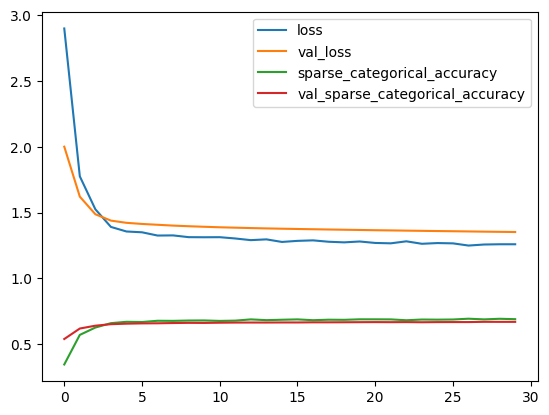

In [28]:
Xception_history_frame = pd.DataFrame(Xception_training.history)
ax = Xception_history_frame.loc[:, ['loss', 'val_loss']].plot()
Xception_history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax = ax)

# Step 7: Model_2 - Custom CNN

In [29]:
"""
Funny thing. When I add preprocessing, TPU refuses to train the model. GPU doesn't bother.
If you understand this, please share your insight.
"""

with strategy.scope():
    custom_model = keras.Sequential([
        L.InputLayer(input_shape=[*IMAGE_SIZE, 3]),
#         preprocessing.RandomFlip(mode='horizontal'),            
#         preprocessing.RandomFlip(mode='vertical'),     
#         preprocessing.RandomRotation(factor=0.20),

         # Block One
        L.BatchNormalization(renorm=True),
        L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        L.MaxPool2D(),

        # Block Two
        L.BatchNormalization(renorm=True),
        L.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        L.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        L.MaxPool2D(),

        # Block Three
        L.BatchNormalization(renorm=True),
        L.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        L.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        L.MaxPool2D(),

        # Head
        L.GlobalAveragePooling2D(),                    # attach a new head (GlobalAveragePooling averages feature maps produced by the base down to a single value per feature. Which is just right for a classification)
        L.Dropout(0.3),                                # add regularization 
        L.Dense(len(CLASSES), activation='softmax')    # output layer where
                                                       # number of neurons corresponds to the number of classes          
    ])
    
    custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 192, 192, 3)       21        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 192, 192, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_5 (Bat  (None, 96, 96, 64)        448       
 chNormalization)                                                
                                                      

In [30]:
custom_model.compile(
    optimizer = 'nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [31]:
# Checkpoint for the second model
custom_model_checkpoint_filepath = 'custom_model.h5'

custom_model_checkpoint = ModelCheckpoint(
                        filepath=custom_model_checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
)

In [32]:
# custom_model_training = custom_model.fit(
#                 ds_train,
#                 validation_data=ds_valid,
#                 epochs=EPOCHS,
#                 steps_per_epoch=STEPS_PER_EPOCH,
#                 callbacks=[
#                     lr_callback,
#                     early_stopping,
#                     custom_model_checkpoint
#                 ]
# )

# joblib.dump (custom_model_training, 'custom_model.pkl')
custom_model_training = joblib.load ('/kaggle/input/cv-course-practical-guide-data/custom_model.pkl')

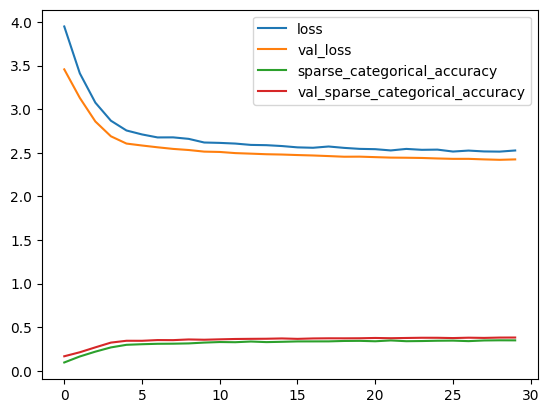

In [33]:
"""
Naturally, the 'Custom Convolutional Neural Network' is a world apart from a pre-trained base like Xception. 
Its role here is to assert its existence — a cherished creation, born through painstaking effort and nurtured with love.
Seriously, I belive everyone should make his own working CNN before going to 'Transfer Learning'.
Mine is working 😎
"""

history_frame = pd.DataFrame(custom_model_training.history)
ax = history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(ax = ax);

# Step 7: Visual Validation
- We will apply our **display_batch_of_images()** function to see the flowers, their predicted and true classes.
- **Visual validation** can help reveal patterns of images the model has trouble with.

In [34]:
# Visual validation
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)     # Display 20 images at a time. Fill free to put your number
batch = iter(dataset)

1/1 [==============================] - 0s 423ms/step


2023-11-16 07:46:03.324368: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-16 07:46:03.324506: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


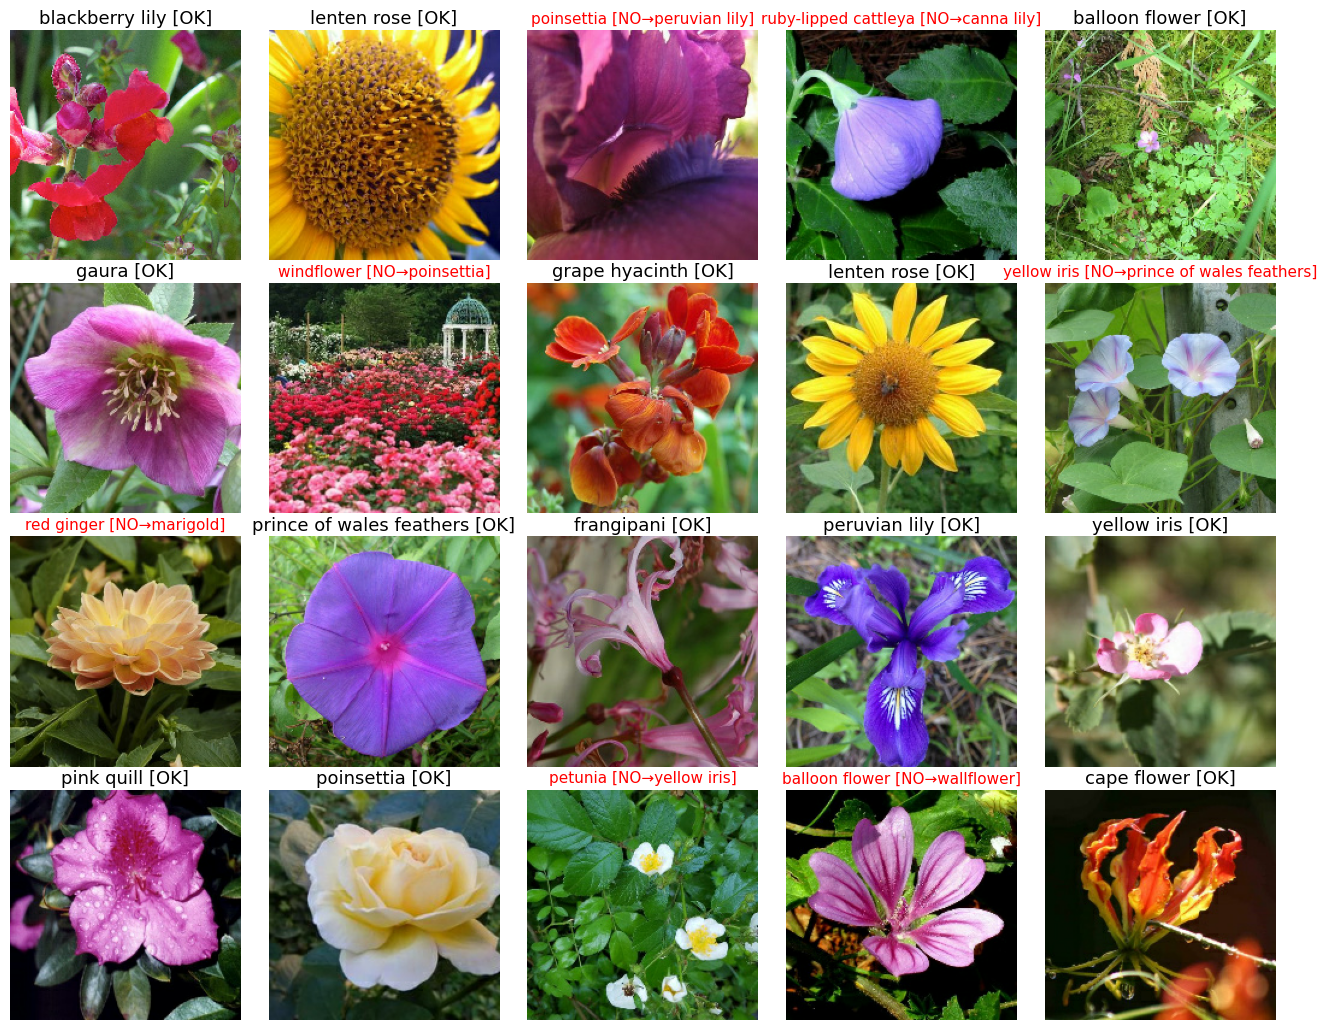

In [41]:
# Xception
# Run the cell again to see another set
images, labels = next(batch)
probabilities = Xception_.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

1/1 [==============================] - 0s 427ms/step


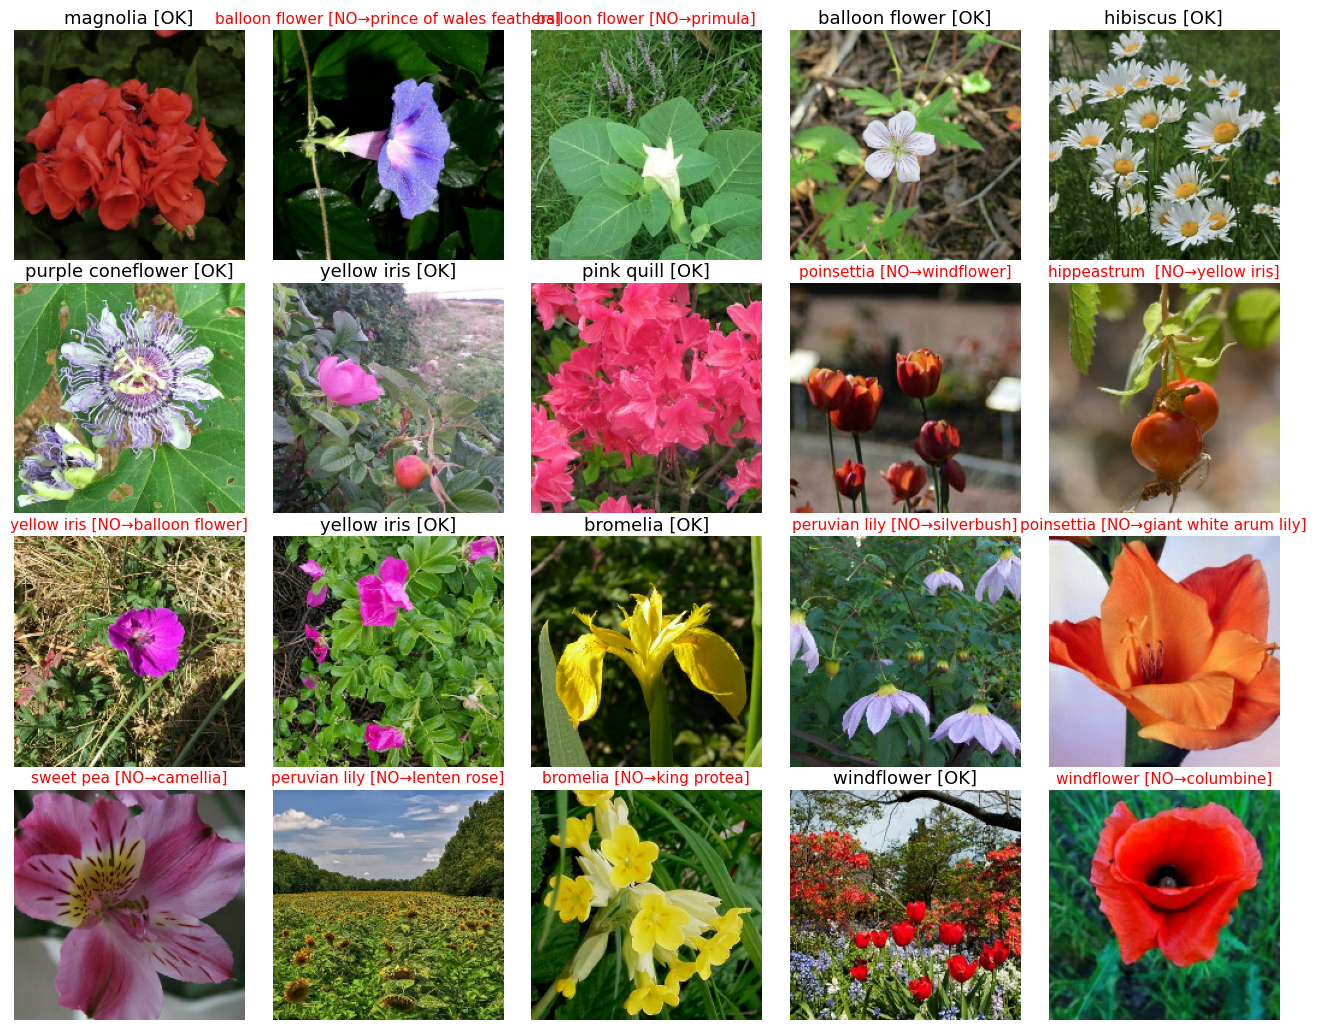

In [43]:
# custom_model
# Run the cell again to see another set
images, labels = next(batch)
probabilities = custom_model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 9: Ensemble

29/29 [==============================] - 2s 35ms/step
Correct labels:  (3712,) [ 12  95   0 ... 102  49  50]
Predicted labels:  (3712,) [ 12  84   0 ... 102  49  50]
best_alpha: 0.71


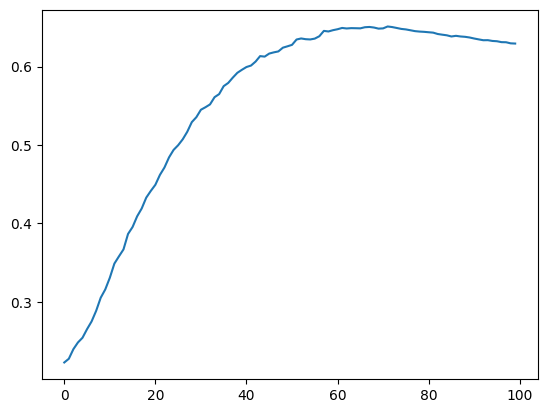

In [44]:
cmdataset = get_validation_dataset(ordered=True)                               # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)                          # makes a data set of images only
labels_ds = cmdataset.map(lambda image, label: label).unbatch()                # makes a data set of labels only

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # gets everything as one batch in np.array format.

Xception_.load_weights('/kaggle/input/cv-course-practical-guide-data/Xception.h5')
custom_model.load_weights('/kaggle/input/cv-course-practical-guide-data/custom_model.h5')

predictions_1 = Xception_.predict(images_ds)
predictions_2 = custom_model.predict(images_ds)

scores = []                                                                  # creat a list to store F1 scores for different alpha values. 
for alpha in np.linspace(0,1,100):                                           # alpha is one of 100 evenly spaced values in range from 0 to 1
    cm_probabilities = alpha * predictions_1 + (1-alpha) * predictions_2     # Combine predictions from two models using the alpha weight
    cm_predictions = np.argmax(cm_probabilities, axis=-1)                    # For each example, select the class with the highest probability as the predicted class.
    scores.append(f1_score(cm_correct_labels,                                # Calculate the F1 score between the correct labels 
                           cm_predictions,                                   # and the combined predictions.
                           labels=range(len(CLASSES)),                       # It computes the F1 score for each class 
                           average='macro'))                                 # and returns the macro-average.

print("Correct labels: ",   cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape,    cm_predictions)
plt.plot(scores)

best_alpha = np.argmax(scores)/100                                           # 'scores' is a list of 100 avarage F1 values. We find the index of max F1 value. When we devide this index (e.g.35) by 100, we find our alpha, that produced that F1 index. Tricky, but elegant.
print (f'best_alpha: {best_alpha}')

# Step 10: Make Test Predictions

In [45]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)

m1 = Xception_.predict(test_images_ds)
m2 = custom_model.predict(test_images_ds)

probabilities = best_alpha*m1+(1-best_alpha)*m2
predictions = np.argmax(probabilities, axis=-1)    # Find the class with the highest probability for each image:  
                                                   # 'predictions' is a sequence of matrixes, where each matrix (idividual prediction) consists of 2 vectors: (1) all the classes (indexes) and (2) probabilities of an image to be that class
                                                   # .argmax() returns index of a maximum value, i.e. class related to the highest probability value
print(predictions)

Computing predictions...
58/58 [==============================] - 3s 38ms/step
[103  67  82 ...  74 103  50]


In [46]:
print('Generating submission.csv file...')

test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()                # Get image ids from test set 
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')  # convert them to unicode
submission_df = pd.DataFrame({'id': test_ids, 'label': predictions})
submission_df.to_csv('submission.csv', index=False)


# Look at the first few predictions
!head submission.csv

Generating submission.csv file...
id,label
aeb67eefb,103
b9e60ac3b,67
aaa580243,82
53cfc6586,72
252d840db,67
00e4f514e,103
dfc9c6a23,103
8d808a07b,53
1c4736dea,28


**Credits**:
- [Rayn Holbrook](https://www.kaggle.com/ryanholbrook) for the wonderful [Computer Vision course](https://www.kaggle.com/learn/computer-vision)
- [Alexis Cook](https://www.kaggle.com/alexisbcook) [Phil Culliton](https://www.kaggle.com/philculliton) for the [examplary notebook](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission) wich this work is built upon.
- George Zoto's awesome [kernel](https://www.kaggle.com/code/georgezoto/computer-vision-petals-to-the-metal) where I borrowed many techniques to complete this Notebook.


If you liked this notebook, please also check the others:
 - [🗺️Geospatial Analysis Course: Practical Guide](https://www.kaggle.com/ivanlydkin/geospatial-analysis-course-practical-guide)
 - [🕒Time Series Course: A Practical Guide](https://www.kaggle.com/code/ivanlydkin/time-series-course-a-practical-guide)
 - [🛳️Original feature for Titanic](https://www.kaggle.com/code/ivanlydkin/titanic-case-with-some-original-features)

*I hope it was helpful* 🤝<br>
<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions</strong> </blockquote><br> 